In [2]:
from datasets import load_dataset
from transformers import pipeline
import pandas as pd
import matplotlib.pyplot as plt
from transformers import AutoTokenizer

In [3]:
from transformers import AutoTokenizer

model_ckpt="distilbert-base-uncased"

tokenizer=AutoTokenizer.from_pretrained(model_ckpt)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [4]:
def tokenize(batch):

    return tokenizer(batch["statement"], padding=True, truncation=True)

In [5]:

dataset = load_dataset("chengxuphd/liar2")


dataset_encoded = dataset.map(tokenize, batched=True, batch_size=None)
dataset_encoded


README.md: 0.00B [00:00, ?B/s]

train.csv:   0%|          | 0.00/19.0M [00:00<?, ?B/s]

valid.csv: 0.00B [00:00, ?B/s]

test.csv: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/18369 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2297 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2296 [00:00<?, ? examples/s]

Map:   0%|          | 0/18369 [00:00<?, ? examples/s]

Map:   0%|          | 0/2297 [00:00<?, ? examples/s]

Map:   0%|          | 0/2296 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['id', 'label', 'statement', 'date', 'subject', 'speaker', 'speaker_description', 'state_info', 'true_counts', 'mostly_true_counts', 'half_true_counts', 'mostly_false_counts', 'false_counts', 'pants_on_fire_counts', 'context', 'justification', 'input_ids', 'attention_mask'],
        num_rows: 18369
    })
    validation: Dataset({
        features: ['id', 'label', 'statement', 'date', 'subject', 'speaker', 'speaker_description', 'state_info', 'true_counts', 'mostly_true_counts', 'half_true_counts', 'mostly_false_counts', 'false_counts', 'pants_on_fire_counts', 'context', 'justification', 'input_ids', 'attention_mask'],
        num_rows: 2297
    })
    test: Dataset({
        features: ['id', 'label', 'statement', 'date', 'subject', 'speaker', 'speaker_description', 'state_info', 'true_counts', 'mostly_true_counts', 'half_true_counts', 'mostly_false_counts', 'false_counts', 'pants_on_fire_counts', 'context', 'justification', 'input_i

In [6]:
# According to the LIAR dataset documentation, the labels are mapped as follows:
# 0: 'pants-fire'
# 1: 'false'
# 2: 'barely-true'
# 3: 'half-true'
# 4: 'mostly-true'
# 5: 'true'

label_mapping = {
    0: 'pants-fire',
    1: 'false',
    2: 'barely-true',
    3: 'half-true',
    4: 'mostly-true',
    5: 'true'
}

print(label_mapping)

{0: 'pants-fire', 1: 'false', 2: 'barely-true', 3: 'half-true', 4: 'mostly-true', 5: 'true'}


In [7]:
from transformers import AutoModelForSequenceClassification

num_labels = 6
model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_labels)


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [8]:
from sklearn.metrics import accuracy_score, f1_score
def compute_metrics(pred):
  labels = pred.label_ids
  preds = pred.predictions.argmax(-1)
  f1 = f1_score(labels, preds, average="weighted")
  acc = accuracy_score(labels, preds)
  return {"accuracy": acc, "f1": f1}

In [9]:

from huggingface_hub import notebook_login
notebook_login()


In [14]:

from transformers import Trainer, TrainingArguments
batch_size = 16
logging_steps = len(dataset_encoded["train"]) // batch_size
model_name = f"{model_ckpt}-finetuned-liar2"
training_args = TrainingArguments(output_dir=model_name,
 num_train_epochs=4,
learning_rate=2e-5,
per_device_train_batch_size=batch_size,
per_device_eval_batch_size=batch_size,
weight_decay=0.01,
eval_strategy="epoch",
 disable_tqdm=False,
 logging_steps=logging_steps,
 push_to_hub=True,
log_level="error")


In [15]:
trainer= Trainer(model=model,args=training_args,compute_metrics=compute_metrics,train_dataset=dataset_encoded["train"],eval_dataset=dataset_encoded["test"],tokenizer=tokenizer)

/tmp/ipython-input-1133488926.py:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer= Trainer(model=model,args=training_args,compute_metrics=compute_metrics,train_dataset=dataset_encoded["train"],eval_dataset=dataset_encoded["test"],tokenizer=tokenizer)


In [16]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,1.341600,1.578602,0.342334,0.329295
2,1.168600,1.666800,0.338850,0.330202
3,1.020900,1.824542,0.333188,0.327981
4,0.849500,1.963815,0.327091,0.325041


TrainOutput(global_step=4596, training_loss=1.0948427470483606, metrics={'train_runtime': 849.9044, 'train_samples_per_second': 86.452, 'train_steps_per_second': 5.408, 'total_flos': 2148295283037072.0, 'train_loss': 1.0948427470483606, 'epoch': 4.0})

In [17]:


trainer.push_to_hub(commit_message="Training completed!")


Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

  ...d-finetuned-liar2/training_args.bin: 100%|##########| 5.84kB / 5.84kB            

  ...ents.1758449060.b2ae4bf0f306.1111.0: 100%|##########| 6.69kB / 6.69kB            

  ...d-finetuned-liar2/model.safetensors:   6%|6         | 16.7MB /  268MB            

  ...ents.1758449634.b2ae4bf0f306.1111.1: 100%|##########| 7.91kB / 7.91kB            

CommitInfo(commit_url='https://huggingface.co/Aditya161205/distilbert-base-uncased-finetuned-liar2/commit/6f100a1b56a4a3479069bbe6fc6369d0b822b892', commit_message='Training completed!', commit_description='', oid='6f100a1b56a4a3479069bbe6fc6369d0b822b892', pr_url=None, repo_url=RepoUrl('https://huggingface.co/Aditya161205/distilbert-base-uncased-finetuned-liar2', endpoint='https://huggingface.co', repo_type='model', repo_id='Aditya161205/distilbert-base-uncased-finetuned-liar2'), pr_revision=None, pr_num=None)

In [18]:

model_id= "Aditya161205/distilbert-base-uncased-finetuned-liar2"
classifier = pipeline("text-classification", model=model_id)

config.json:   0%|          | 0.00/831 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [68]:

custom= "Taxes on the middle class have more than doubled in the last four years."
preds= classifier(custom, return_all_scores=True)
preds

[[{'label': 'LABEL_0', 'score': 0.010560824535787106},
  {'label': 'LABEL_1', 'score': 0.06200748309493065},
  {'label': 'LABEL_2', 'score': 0.018930446356534958},
  {'label': 'LABEL_3', 'score': 0.09531320631504059},
  {'label': 'LABEL_4', 'score': 0.4378173351287842},
  {'label': 'LABEL_5', 'score': 0.37537074089050293}]]

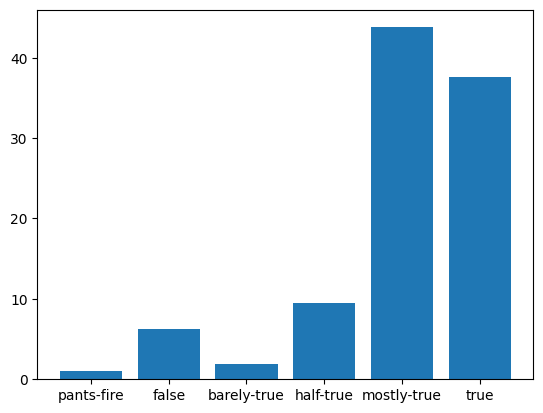

In [74]:
df=pd.DataFrame(preds[0])

df['label'] = df['label'].apply(lambda x: label_mapping[int(x.split('_')[1])])
plt.bar(df['label'],100*df["score"])
plt.show()